In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torcheval.metrics.functional import r2_score

In [3]:
from src.models import FCN, FCN_with_last_activation, FCN_with_parallel_branch
from src.data_handler import DataHandler, DataHandlerForAllSimulations, RandomSamplingDataHandler
from src.experiment_run import RunAllSimulations, Run
from src.constants import TIMESTEP_SCALE, GAMMA_SCALE, N_SCALE
from src.physics_loss import physics_loss_fixed_gamma_n, physics_loss_varied_gamma_n

In [4]:
def run_eval(x, y, run):
    print("R^2 score of the model: ", run.score().item())
    plt.plot(x, run.model(x).detach().numpy(), label="predicted ionization fraction")
    plt.plot(x, y, label="true ionization fraction")
    plt.xlabel("timestep")
    plt.ylabel("Ionized hydrogen fraction")
    plt.legend()

def all_run_eval(run, mode="Timestep"):
    r2_scores, pred_best, y_best, pred_worst, y_worst = run.test()
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
    ax[0].plot(pred_best.detach().numpy(), label="Prediction")
    ax[0].plot(y_best.detach().numpy(), label="Target")
    ax[0].set_xlabel(mode)
    ax[0].set_ylabel("Ionized hydrogen fraction")
    ax[0].set_title(f"The most accurate approximation, R2={np.max(r2_scores)}")
    ax[0].legend()
    ax[1].plot(pred_worst.detach().numpy(), label="Prediction")
    ax[1].plot(y_worst.detach().numpy(), label="Target")
    ax[1].set_xlabel(mode)
    ax[1].set_ylabel("Ionized hydrogen fraction")
    ax[1].set_title(f"The least accurate approximation, R2={np.min(r2_scores)}")
    ax[1].legend()
    plt.show()
    return r2_scores

In this notebook we test the **generalization** ability of PINN.

Our train and test data for ionized hydrogen fraction prediction are generated by pyC2Ray chemistry ODE solver. It has 2 phases: 
1. estimation of astrophysics parameters $\Gamma (t)$ and $nH(t)$ (optional)
2. numerical solution of the Hydrogen ODE for each timestep

but if $\Gamma (t) = \Gamma$ and $nH(t)= nH$ are constant in time, it reduces to a single phase:
1. numerical solution of the Hydrogen ODE for each timestep

We were provided with $N\_train = 2000$ 1-phase simulations for training/validation and with a single 2-phase simulation for testing. Full 2-phase generating is very computationally intensive so the simulation was obtained only for the last timestep. However, it allows us to check the generalization ability of trained PINN. It should reconstruct the distribution of ionized fraction not only in time, but also in space.

In [5]:
train_t_steps = 10000 # time grid

# define the Universe time
train_u_time = np.arange(train_t_steps)

In [6]:
test_n_units = 50 # space grid
test_u_time = 1000 # last timestep of the test simulation

In [7]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

Data loading

In [8]:
train_data = np.load('data/test1.npy').T
train_data.shape

(2000, 10000)

In [9]:
train_params = pd.read_csv('data/params1.txt', sep=' ')
train_params = train_params.values
train_params.shape

(2000, 2)

In [10]:
test_data = np.load('data/sim_cosm/xHII_z9.026.npy')
test_data = test_data[:test_n_units, :test_n_units, :test_n_units]

In [11]:
test_gamma = np.load("data/sim_cosm/gamma_z9.026.npy")
test_ngas = np.load("data/sim_cosm/ngas_z9.026.npy")

test_gamma = test_gamma[:test_n_units, :test_n_units, :test_n_units]
test_ngas = test_ngas[:test_n_units, :test_n_units, :test_n_units]

Our training simulations contain ionized fraction along X-axis only, but test simulations contain all possible directions so we consider X, Y, Z projections

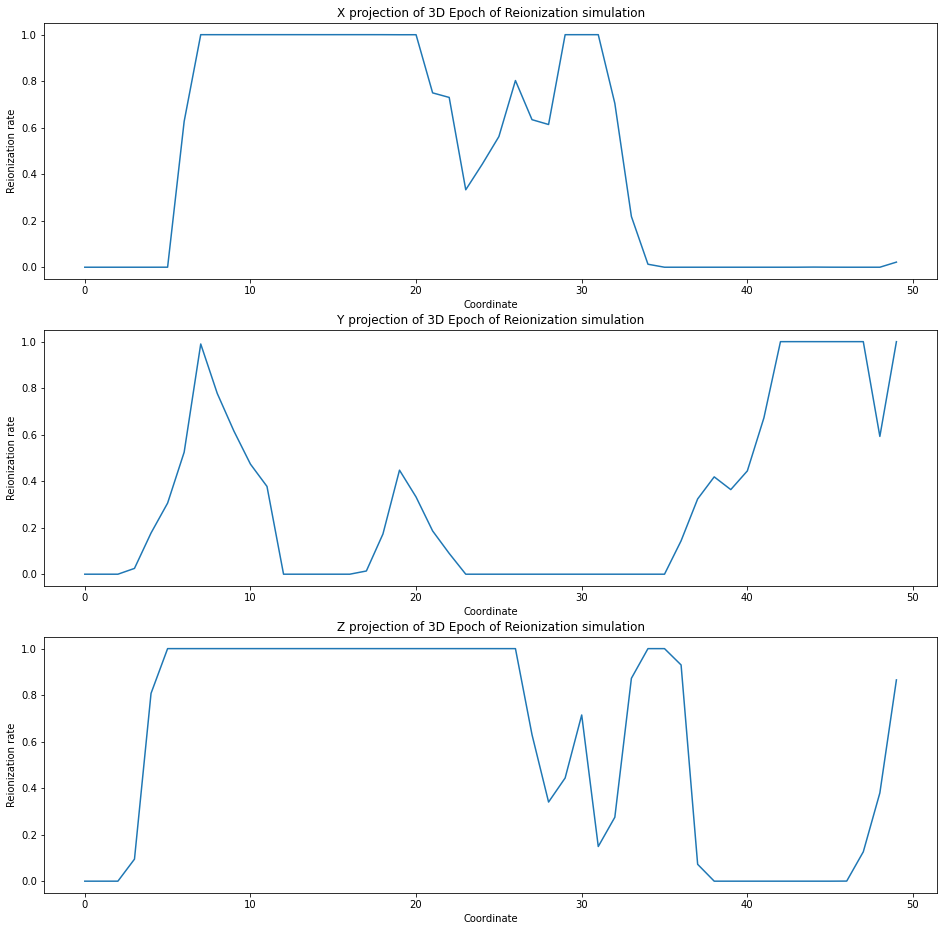

In [12]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(16,16))
ax[0].plot(test_data[:, 0, 0])
ax[0].set_xlabel("Coordinate")
ax[0].set_ylabel("Reionization rate")
ax[0].set_title(f"X projection of 3D Epoch of Reionization simulation")
ax[1].plot(test_data[0, :, 0])
ax[1].set_xlabel("Coordinate")
ax[1].set_ylabel("Reionization rate")
ax[1].set_title(f"Y projection of 3D Epoch of Reionization simulation")
ax[2].plot(test_data[0, 0, :])
ax[2].set_xlabel("Coordinate")
ax[2].set_ylabel("Reionization rate")
ax[2].set_title(f"Z projection of 3D Epoch of Reionization simulation")
plt.show()

We compare the best training pipelines that we found during experiments with 1-phase simulations: with and without physics loss. For more details please refer to PINN_for_hydrogen_ionization.ipynb

1-phase simulations preprocessing

In [13]:
train_timesteps = torch.tensor(train_u_time).float().view(-1,1)
y_train = torch.tensor(train_data).float()

In [14]:
x_train = torch.zeros((2000, 10000, 3)) # n_simulations * n_timesteps * feature_dim
for i, row in enumerate(train_params):
    row = row * np.array([N_SCALE, GAMMA_SCALE])
    row_2d = np.broadcast_to(row, (10000, 2))
    row_2d = torch.tensor(row_2d).float()
    x_train[i] = torch.hstack((train_timesteps * TIMESTEP_SCALE, row_2d))
print(x_train[0, 0:5, :])

tensor([[0.0000e+00, 1.6522e-02, 1.6896e+00],
        [1.0000e-04, 1.6522e-02, 1.6896e+00],
        [2.0000e-04, 1.6522e-02, 1.6896e+00],
        [3.0000e-04, 1.6522e-02, 1.6896e+00],
        [4.0000e-04, 1.6522e-02, 1.6896e+00]])


2-phase simulation preprocessing: X, Y, Z projections and last timestep are under consideration

In [15]:
test_timesteps = test_u_time * torch.ones(test_n_units).float().view(-1,1)
xyz_projections = np.vstack([test_data[:, 0, 0], test_data[0, :, 0], test_data[0, 0, :]])
y_test = torch.tensor(xyz_projections).float()

In [16]:
x_test = torch.zeros((3, 50, 3)) # n_projections * n_timesteps * feature_dim
test_params = np.vstack([test_ngas[:, 0, 0], test_gamma[:, 0, 0], 
                        test_ngas[0, :, 0], test_gamma[0, :, 0], 
                        test_ngas[0, 0, :], test_gamma[0, 0, :]]).T
test_params = torch.tensor(test_params).float()
# scaling factors along different axis are different
scaling_factors = [N_SCALE, GAMMA_SCALE * 1e1, N_SCALE, GAMMA_SCALE * 1e2, N_SCALE, GAMMA_SCALE * 1e2]
for i in range(3):
    proj_params = test_params[:, 2*i:2*(i+1)]
    proj_params = proj_params * np.array(scaling_factors[2*i:2*(i+1)])
    x_test[i] = torch.hstack((test_timesteps * TIMESTEP_SCALE, proj_params))
print(x_test[1, 0:5, :])

tensor([[0.1000, 0.1163, 0.0000],
        [0.1000, 0.1260, 0.0000],
        [0.1000, 0.1458, 0.0000],
        [0.1000, 0.2212, 0.0671],
        [0.1000, 0.2192, 0.3115]])


Training on 1-phase simulations **without physics loss**

In [18]:
parallel_model = FCN_with_parallel_branch([1, 8, 8, 8], [2, 8, 8, 8], [ 8, 8, 8, 1], last_activation=torch.nn.Tanh)
optimizer = torch.optim.Adam(parallel_model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, patience=500,)

run = RunAllSimulations('multi_sim_without_physics_parallel_branches')

run.data_handler = DataHandlerForAllSimulations(x_train, y_train, resample_ood_runs=True, ood_weight=0., normal_weight=1.)
run.model = parallel_model
run.optimizer = optimizer
run.scheduler = scheduler
run.data_loss = torch.nn.MSELoss()
run.physics_loss = None 

run.train(10)

  0%|          | 0/10 [00:00<?, ?it/s]

Total num of the batches:  1800


100%|██████████| 10/10 [00:40<00:00,  4.05s/it]


R2 best simulation:  0.9986821
R2 worst simulation:  -16.26326


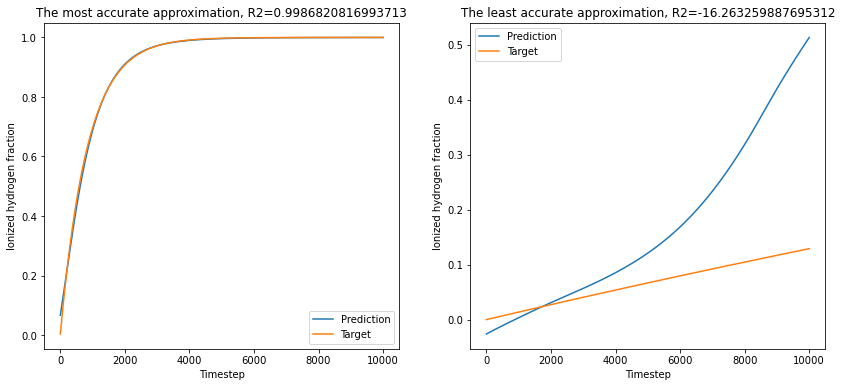

In [19]:
r2_scores_on_validation = all_run_eval(run, mode="Timestep")

Testing on 2-phase simulation

R2 best simulation:  0.8881835
R2 worst simulation:  0.6448492


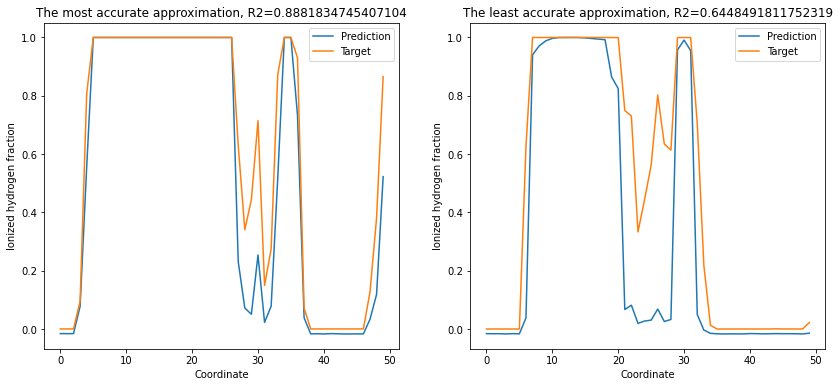

In [20]:
run.data_handler = DataHandlerForAllSimulations(x_test, y_test, resample_ood_runs=False, train_fraction=0.0, 
                                                 ood_weight=0., normal_weight=1.)
r2_scores_on_test = all_run_eval(run, mode="Coordinate")

Training on 1-phase simulations **with physics loss**

In [21]:
parallel_model = FCN_with_parallel_branch([1, 8, 8, 8], [2, 8, 8, 8], [ 8, 8, 8, 1], last_activation=torch.nn.Tanh)
optimizer = torch.optim.Adam(parallel_model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, patience=500,)

run = RunAllSimulations('multi_sim_with_physics_parallel_branches')

run.data_handler = DataHandlerForAllSimulations(x_train, y_train, resample_ood_runs=True, ood_weight=0., normal_weight=1.)
run.model = parallel_model
run.optimizer = optimizer
run.scheduler = scheduler
run.data_loss = torch.nn.MSELoss()
run.physics_loss = lambda x, y: physics_loss_varied_gamma_n(x, y, loss_coef=1e5)

run.train(10)

  0%|          | 0/10 [00:00<?, ?it/s]

Total num of the batches:  1800


100%|██████████| 10/10 [01:29<00:00,  9.00s/it]


R2 best simulation:  0.9808155
R2 worst simulation:  -37.57669


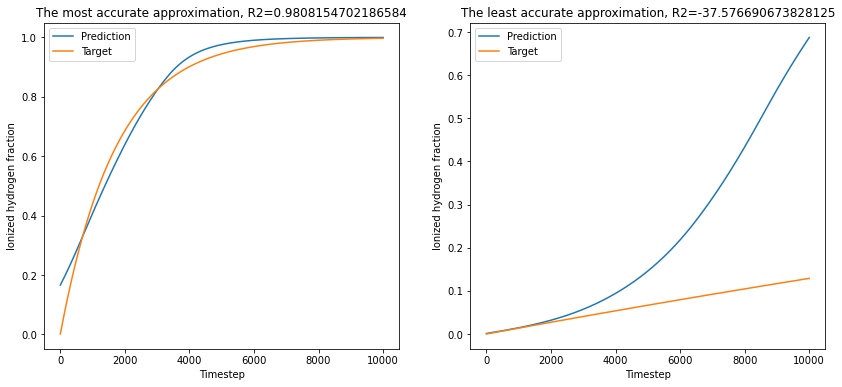

In [22]:
r2_scores_on_validation = all_run_eval(run, mode="Timestep")

R2 best simulation:  0.89192885
R2 worst simulation:  0.6453587


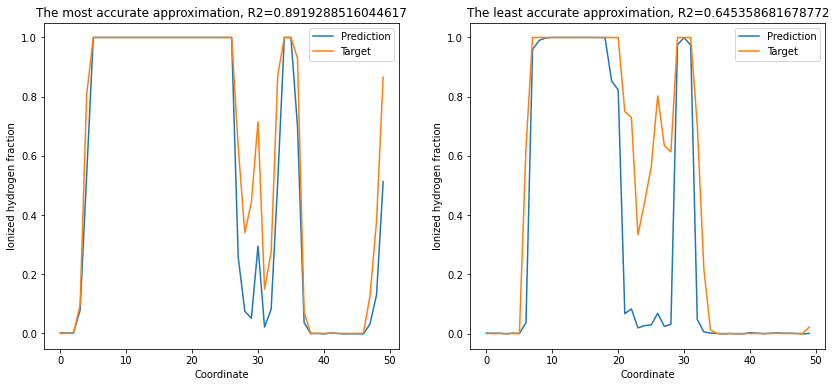

In [24]:
run.data_handler = DataHandlerForAllSimulations(x_test, y_test, resample_ood_runs=False, train_fraction=0.0, 
                                                 ood_weight=0., normal_weight=1.)
r2_scores_on_test = all_run_eval(run, mode="Coordinate")

These experiments prove that Physic-informed Neural Network (2nd setup with physics loss) can generalize better than Naive Approach (1st setup without physics loss). Despite the fact that PINN was trained to capture **temporal** distribution of ionized hydrogen fraction and approximate **smooth** functions without peaks, it can capture **spatial** distribution reasonably well.